In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Activation, BatchNormalization, Input, Dropout
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

print(f' ------------- \n',
      f'Versions: \n',
      f'------------- \n'
      f' numpy=={np.__version__} \n'
      f' tensorflow=={tf.__version__} \n'
      f' sklearn=={sklearn.__version__} \n'
      f' keras=={keras.__version__} \n'
     )

 ------------- 
 Versions: 
 ------------- 
 numpy==1.22.1 
 tensorflow==2.11.1 
 sklearn==1.2.1 
 keras==2.11.0 



- ## Importing data:

In [2]:
def importData(interface_of_interest, direction_of_interest):

    random_fields_path = f'./data/{interface_of_interest}_{direction_of_interest}/random_fields/'
    lst = os.listdir(random_fields_path)
    random_field_files = [os.path.join(random_fields_path,el) for el in lst]
    random_field_list = []
    for file in random_field_files:
        with open(file, 'rb') as fp:
            random_field_list.append(pickle.load(fp))
    random_field_list = np.array(random_field_list)
    random_field_list = random_field_list.reshape(random_field_list.shape[:2])


    damages_path = f'./data/{interface_of_interest}_{direction_of_interest}/damages/'
    lst = os.listdir(damages_path)
    damage_files = [os.path.join(damages_path, el) for el in lst]
    damage_list = []
    for file in damage_files:
        with open(file, 'rb') as fp:
            damage_list.append(pickle.load(fp))
    damage_list = np.array(damage_list)
    damage_list = damage_list.reshape(damage_list.shape[:2])

    scattered_fields_path = f'./data/{interface_of_interest}_{direction_of_interest}/scattered_fields/'
    lst = os.listdir(scattered_fields_path)
    scattered_field_files = [os.path.join(scattered_fields_path, el) for el in lst]
    scattered_field_x_list = []
    scattered_field_z_list = []
    for file in scattered_field_files:
        with open(file, 'rb') as fp:
            scattered_field_sample = pickle.load(fp)
            scattered_field_x_list.append(scattered_field_sample[0, :])
            scattered_field_z_list.append(scattered_field_sample[2, :])
    scattered_field_x_list = np.array(scattered_field_x_list)
    scattered_field_x_list = scattered_field_x_list.reshape(scattered_field_x_list.shape[:2])
    scattered_field_z_list = np.array(scattered_field_z_list)
    scattered_field_z_list = scattered_field_z_list.reshape(scattered_field_z_list.shape[:2])

    specular_field_file = f'./data/{interface_of_interest}_{direction_of_interest}/u_spec'
    cov_matrix_file = f'./data/{interface_of_interest}_{direction_of_interest}/cov_matrix'

    with open(specular_field_file, 'rb') as fp:
        specular_field = pickle.load(fp)
    specular_field_x = specular_field[0, :]
    specular_field_z = specular_field[2, :]

    with open(cov_matrix_file, 'rb') as fp:
        cov_matrix = pickle.load(fp)
        
    with open(f'./results/modes_parameters/x_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        x = pickle.load(fp)
        
    return (
        random_field_list,
        damage_list,
        scattered_field_x_list,
        scattered_field_z_list,
        specular_field_x,
        specular_field_z,
        cov_matrix,
        x
    )

In [53]:
interface_of_interest = 'copper-stainless steel'
direction_of_interest = 'xx'

(
    random_field_list,
    damage_list,
    scattered_field_x_list,
    scattered_field_z_list,
    specular_field_x,
    specular_field_z,
    cov_matrix,
    x_space
) = importData(
     interface_of_interest,
     direction_of_interest
 )

- ## Data Pre-Processing:

In [56]:
# Defining the reduced model points
def model_reducing(n_points, X, y):
    idx = np.round(np.linspace(0, X.shape[1] - 1, n_points)).astype(int)
    X_reduced = X[:, idx]
    y_reduced = y[:, idx]
    x_space_reduced = x_space[idx]
    return X_reduced, y_reduced, x_space_reduced

reduced_model_points=None

X = np.real(scattered_field_x_list) # z_list
y = np.real(random_field_list)

if reduced_model_points:
    X, y, x_space = model_reducing(reduced_model_points, X, y)

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.1
)

- ## Neural Network Architecture:

In [60]:
input_layer = Input(X.shape[1])
x = Dense(64)(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(64)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
output_layer = Dense(y.shape[-1])(x)
model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer='adam'
)
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 120)]             0         
                                                                 
 dense_30 (Dense)            (None, 64)                7744      
                                                                 
 batch_normalization_20 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_21 (Bat  (None, 64)               256       
 chNormalization)                                         

Epoch 1/1000
282/282 [==============================] - 1s 2ms/step - loss: 0.5819 - val_loss: 0.4999
Epoch 2/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.4556 - val_loss: 0.4226
Epoch 3/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.4146 - val_loss: 0.3925
Epoch 4/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.3913 - val_loss: 0.3738
Epoch 5/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.3764 - val_loss: 0.3596
Epoch 6/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.3646 - val_loss: 0.3500
Epoch 7/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.3549 - val_loss: 0.3395
Epoch 8/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.3468 - val_loss: 0.3323
Epoch 9/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.3399 - val_loss: 0.3267
Epoch 10/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.332

282/282 [==============================] - 0s 1ms/step - loss: 0.2231 - val_loss: 0.2109
Epoch 160/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2232 - val_loss: 0.2087
Epoch 161/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2234 - val_loss: 0.2165
Epoch 162/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2232 - val_loss: 0.2115
Epoch 163/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2232 - val_loss: 0.2078
Epoch 164/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2226 - val_loss: 0.2200
Epoch 165/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2225 - val_loss: 0.2189
Epoch 166/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2233 - val_loss: 0.2112
Epoch 167/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2217 - val_loss: 0.2366
Epoch 168/1000
282/282 [==============================] - 0s 1ms/step - loss: 0

Epoch 238/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2147 - val_loss: 0.2137
Epoch 239/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2151 - val_loss: 0.2099
Epoch 240/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2146 - val_loss: 0.1996
Epoch 241/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2156 - val_loss: 0.2132
Epoch 242/1000
282/282 [==============================] - 0s 2ms/step - loss: 0.2146 - val_loss: 0.2001
Epoch 243/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2144 - val_loss: 0.2035
Epoch 244/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2142 - val_loss: 0.2124
Epoch 245/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2144 - val_loss: 0.2136
Epoch 246/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2144 - val_loss: 0.2235
Epoch 247/1000
282/282 [==============================] - 0s 1ms

Epoch 317/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2101 - val_loss: 0.2282
Epoch 318/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2090 - val_loss: 0.2077
Epoch 319/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2098 - val_loss: 0.2022
Epoch 320/1000
282/282 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.2662
Epoch 321/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2088 - val_loss: 0.1979
Epoch 322/1000
282/282 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.2038
Epoch 323/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2090 - val_loss: 0.2085
Epoch 324/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2090 - val_loss: 0.2034
Epoch 325/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2094 - val_loss: 0.1918
Epoch 326/1000
282/282 [==============================] - 0s 1ms

Epoch 396/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2050 - val_loss: 0.2131
Epoch 397/1000
282/282 [==============================] - 0s 2ms/step - loss: 0.2048 - val_loss: 0.2016
Epoch 398/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2052 - val_loss: 0.1994
Epoch 399/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2049 - val_loss: 0.1995
Epoch 400/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2050 - val_loss: 0.1978
Epoch 401/1000
282/282 [==============================] - 0s 2ms/step - loss: 0.2046 - val_loss: 0.1926
Epoch 402/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2047 - val_loss: 0.1991
Epoch 403/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2051 - val_loss: 0.2046
Epoch 404/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2056 - val_loss: 0.2389
Epoch 405/1000
282/282 [==============================] - 0s 1ms

Epoch 475/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2018 - val_loss: 0.1898
Epoch 476/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2013 - val_loss: 0.1934
Epoch 477/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2023 - val_loss: 0.2003
Epoch 478/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2017 - val_loss: 0.1971
Epoch 479/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2018 - val_loss: 0.1901
Epoch 480/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2023 - val_loss: 0.2056
Epoch 481/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2020 - val_loss: 0.1891
Epoch 482/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2014 - val_loss: 0.2027
Epoch 483/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.2022 - val_loss: 0.1912
Epoch 484/1000
282/282 [==============================] - 0s 1ms

Epoch 554/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1989 - val_loss: 0.1900
Epoch 555/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1991 - val_loss: 0.1967
Epoch 556/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1990 - val_loss: 0.1949
Epoch 557/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1991 - val_loss: 0.1887
Epoch 558/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1990 - val_loss: 0.1857
Epoch 559/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1988 - val_loss: 0.1945
Epoch 560/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1987 - val_loss: 0.1842
Epoch 561/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1987 - val_loss: 0.2287
Epoch 562/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1990 - val_loss: 0.1820
Epoch 563/1000
282/282 [==============================] - 0s 1ms

Epoch 633/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1968 - val_loss: 0.1844
Epoch 634/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1968 - val_loss: 0.1910
Epoch 635/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1963 - val_loss: 0.1908
Epoch 636/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1969 - val_loss: 0.1795
Epoch 637/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1967 - val_loss: 0.1815
Epoch 638/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1968 - val_loss: 0.1825
Epoch 639/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1966 - val_loss: 0.2302
Epoch 640/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1969 - val_loss: 0.1840
Epoch 641/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1972 - val_loss: 0.2008
Epoch 642/1000
282/282 [==============================] - 0s 1ms

Epoch 712/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1955 - val_loss: 0.1853
Epoch 713/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1950 - val_loss: 0.2074
Epoch 714/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1947 - val_loss: 0.1850
Epoch 715/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1954 - val_loss: 0.1802
Epoch 716/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1952 - val_loss: 0.1847
Epoch 717/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1955 - val_loss: 0.1863
Epoch 718/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1948 - val_loss: 0.1812
Epoch 719/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1950 - val_loss: 0.1834
Epoch 720/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1951 - val_loss: 0.1824
Epoch 721/1000
282/282 [==============================] - 0s 1ms

Epoch 791/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1934 - val_loss: 0.1821
Epoch 792/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1932 - val_loss: 0.1968
Epoch 793/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1935 - val_loss: 0.1828
Epoch 794/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1937 - val_loss: 0.1889
Epoch 795/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1932 - val_loss: 0.1930
Epoch 796/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1932 - val_loss: 0.1787
Epoch 797/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1938 - val_loss: 0.1813
Epoch 798/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1936 - val_loss: 0.1909
Epoch 799/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1935 - val_loss: 0.1861
Epoch 800/1000
282/282 [==============================] - 0s 1ms

Epoch 870/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1924 - val_loss: 0.1786
Epoch 871/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1925 - val_loss: 0.1846
Epoch 872/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1917 - val_loss: 0.1829
Epoch 873/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1921 - val_loss: 0.1906
Epoch 874/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1917 - val_loss: 0.1774
Epoch 875/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1917 - val_loss: 0.1766
Epoch 876/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1923 - val_loss: 0.1898
Epoch 877/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1925 - val_loss: 0.1915
Epoch 878/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1915 - val_loss: 0.1845
Epoch 879/1000
282/282 [==============================] - 0s 1ms

Epoch 949/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1907 - val_loss: 0.1781
Epoch 950/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1909 - val_loss: 0.1848
Epoch 951/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1900 - val_loss: 0.1977
Epoch 952/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1912 - val_loss: 0.1736
Epoch 953/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1908 - val_loss: 0.2034
Epoch 954/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1904 - val_loss: 0.1939
Epoch 955/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1901 - val_loss: 0.1807
Epoch 956/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1908 - val_loss: 0.1933
Epoch 957/1000
282/282 [==============================] - 0s 1ms/step - loss: 0.1905 - val_loss: 0.1856
Epoch 958/1000
282/282 [==============================] - 0s 1ms

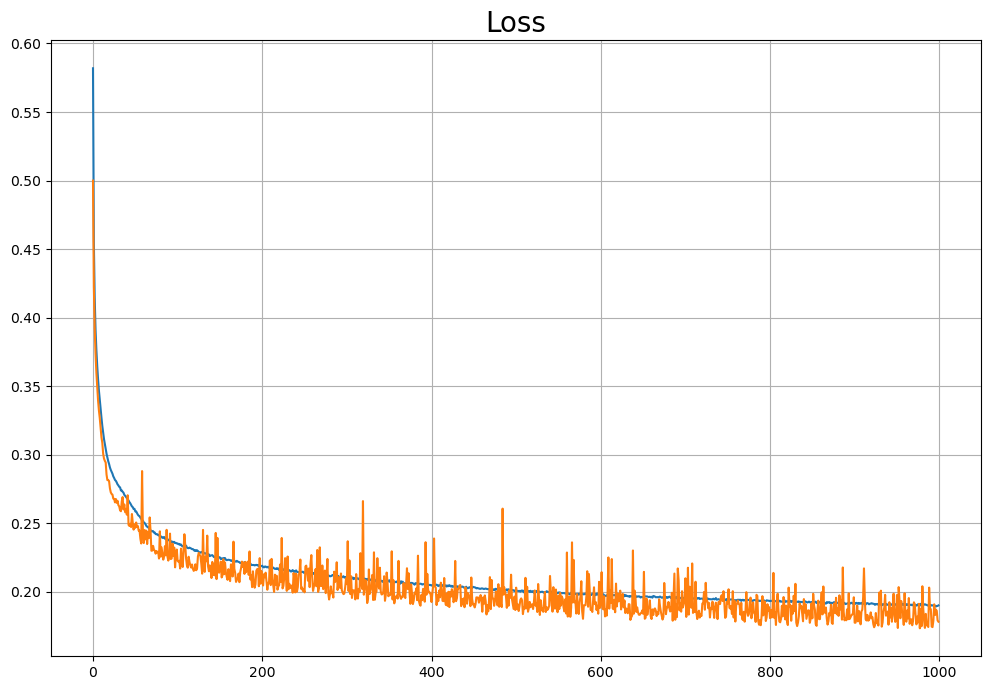

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\activation_1
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\input_layer
......vars
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-08-09 16:42:27         3996
m

In [61]:
def saveModel(model, file_name):
    pickle.dump(model, open(f'./results/models/{file_name}', 'wb'))

history=model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_val, y_val)
)

plt.figure(figsize=(12, 8))
plt.title("Loss", size=20)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(0.5)
plt.show()

if reduced_model_points:
    saveModel(model=model, file_name=f'{direction_of_interest}_{reduced_model_points}_teste')
else:
    saveModel(model=model, file_name=f'{direction_of_interest}_full_teste')

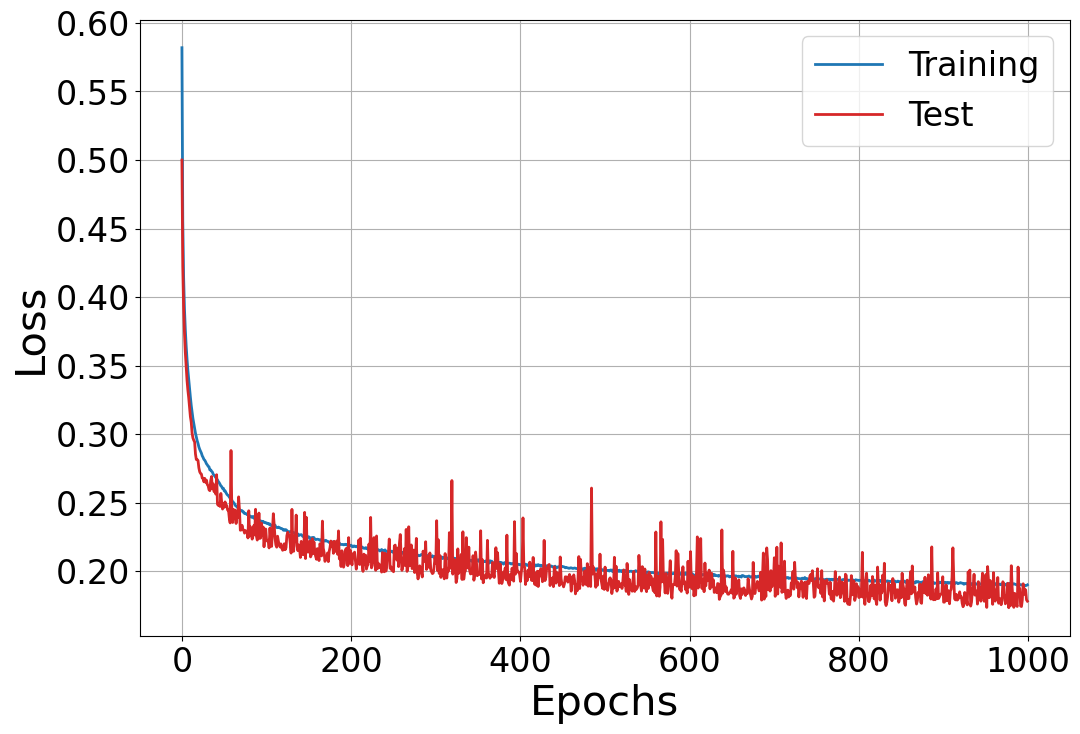

In [62]:
plt.figure(figsize=(12, 8))
plt.ylabel("Loss", size=30)
plt.xlabel("Epochs", size=30)
plt.plot(history.history['loss'], "C0", label='Training', linewidth = 2)
plt.plot(history.history['val_loss'], "C3", label='Test', linewidth = 2)
plt.grid(0.5)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.legend(fontsize=24)
plt.savefig("xx_full_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()